## Fine tunning llama3.2 11B

Training llama3.2 11B model on free google collab GPU wasn't possible. The model in 4 bit quantization required approximately 22GBs.

| **Param**                    | **Value**     |
|-----------------------------|---------------|
| Base Model (4-bit)          | ~5.5 GB       |
| LoRA Adapter                | ~2–3 GB       |
| Optimizer + Checkpointing  | ~4–5 GB       |
| Activations (per batch)     | ~4–8 GB       |
| **Total VRAM**              | **~18–22 GB** |


But after **Unsloth** this is possible.

###Unsloth.ai
optimizes fine-tuning by manually deriving matrix differentials and performing chained matrix multiplications. This approach ensures that operations are carried out with minimal computational overhead, leading to significant performance gains.

###### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
# fourbit_models = [
#     "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
#     "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
#     "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
#     "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

#     "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
#     "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

#     "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
#     "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
#     "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

#     "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
#     "unsloth/llava-1.5-7b-hf-bnb-4bit",
# ] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[In unsloth,]** They also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


###### Data prep

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Moiz2517/Food-101-RecipeDataset", split="train")

README.md:   0%|          | 0.00/2.63k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train-00000-of-00001.parquet:   0%|          | 0.00/42.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/880 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23 [00:00<?, ? examples/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [ ]:
dataset

Dataset({
    features: ['image_id', 'image', 'food_name', 'food_ingredients'],
    num_rows: 880
})

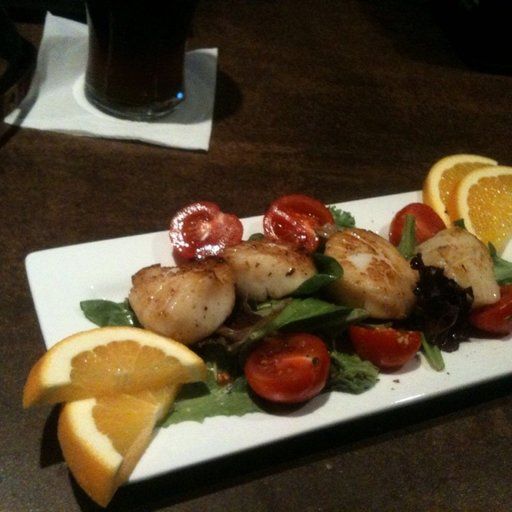

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["food_name"]

'scallops'

In [ ]:
dataset[0]["food_ingredients"]

[{'ingredient': 'scallops', 'quantity': '150', 'unit': 'grams'},
 {'ingredient': 'salad greens', 'quantity': '50', 'unit': 'grams'},
 {'ingredient': 'cherry tomatoes', 'quantity': '50', 'unit': 'grams'},
 {'ingredient': 'lemon', 'quantity': '30', 'unit': 'grams'},
 {'ingredient': 'olive oil', 'quantity': '10', 'unit': 'grams'}]

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [ ]:
from datasets import Dataset
converted_data = []
for row in dataset:
    new_row = {
        "image_id": row["image_id"],
        "image": row["image"],
        "food_details": {
            "food_name": row["food_name"],
            "food_components": row["food_ingredients"]
        }
    }
    converted_data.append(new_row)

# Create a new Hugging Face dataset
new_dataset = Dataset.from_list(converted_data)

In [ ]:
new_dataset

Dataset({
    features: ['image_id', 'image', 'food_details'],
    num_rows: 880
})

In [ ]:
new_dataset[0]['food_details']

{'food_components': [{'ingredient': 'scallops',
   'quantity': '150',
   'unit': 'grams'},
  {'ingredient': 'salad greens', 'quantity': '50', 'unit': 'grams'},
  {'ingredient': 'cherry tomatoes', 'quantity': '50', 'unit': 'grams'},
  {'ingredient': 'lemon', 'quantity': '30', 'unit': 'grams'},
  {'ingredient': 'olive oil', 'quantity': '10', 'unit': 'grams'}],
 'food_name': 'scallops'}

In [ ]:
def convert_to_conversation(sample):
  instruction = f"""
    You are an expert chef.
    The current picture you are observing is an image of a continental dish.
    Your task is to understand the food image and provide the breakdown of the major ingredients with average quantity for 1 person.
    The unit you need to use is in grams.
    For ingredient you need to use simple names. For example, if mozzarella or cheddar cheese is used, call it 'cheese'. If flour is of different type, call it 'flour'.

    In your response only return JSON.
    output = {{
        "food_name": "XXXXXXXXXX",
        "food_components": [
            {{
                "ingredient": "XXXXXX",
                "quantity": "XXXXXXX",
                "unit": "XXXXXXX"
            }},
            ...
        ]
    }}
  """
  conversation = [
    { "role": "user",
      "content" : [
        {"type" : "text",  "text"  : instruction},
        {"type" : "image", "image" : sample["image"]} ]
    },
    { "role" : "assistant",
      "content" : [
        {"type" : "text",  "text"  : sample["food_details"]} ]
    },
  ]
  return { "messages" : conversation }

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in new_dataset]

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': '\n    You are an expert chef.\n    The current picture you are observing is an image of a continental dish.\n    Your task is to understand the food image and provide the breakdown of the major ingredients with average quantity for 1 person.\n    The unit you need to use is in grams.\n    For ingredient you need to use simple names. For example, if mozzarella or cheddar cheese is used, call it \'cheese\'. If flour is of different type, call it \'flour\'.\n    \n    In your response only return JSON.\n    output = {\n        "food_name": "XXXXXXXXXX",\n        "food_components": [\n            {\n                "ingredient": "XXXXXX",\n                "quantity": "XXXXXXX",\n                "unit": "XXXXXXX"\n            },\n            ...\n        ]\n    }\n  '},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}]},
  {'role': 'assistant',
   'content': [{'ty

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!
image_num = 23
image = dataset[image_num]["image"]
instruction = f"""
    You are an expert chef.
    The current picture you are observing is an image of a continental dish.
    Your task is to understand the food image and provide the breakdown of the major ingredients with average quantity for 1 person.
    The unit you need to use is in grams.
    For ingredient you need to use simple names. For example, if mozzarella or cheddar cheese is used, call it 'cheese'. If flour is of different type, call it 'flour'.

    In your response only return JSON.
    output = {{
        "food_name": "XXXXXXXXXX",
        "food_components": [
            {{
                "ingredient": "XXXXXX",
                "quantity": "XXXXXXX",
                "unit": "XXXXXXX"
            }},
            ...
        ]
    }}
  """

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
print(messages)

[{'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': '\n    You are an expert chef.\n    The current picture you are observing is an image of a continental dish.\n    Your task is to understand the food image and provide the breakdown of the major ingredients with average quantity for 1 person.\n    The unit you need to use is in grams.\n    For ingredient you need to use simple names. For example, if mozzarella or cheddar cheese is used, call it \'cheese\'. If flour is of different type, call it \'flour\'.\n    \n    In your response only return JSON.\n    output = {\n        "food_name": "XXXXXXXXXX",\n        "food_components": [\n            {\n                "ingredient": "XXXXXX",\n                "quantity": "XXXXXXX",\n                "unit": "XXXXXXX"\n            },\n            ...\n        ]\n    }\n  '}]}]


In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2000,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The image depicts a platter of sushi, comprising four different types: California roll, cucumber roll, shrimp tempura roll, and a type that cannot be identified due to the blurry quality.

To estimate the quantity of ingredients in grams for one person, we need to analyze the appearance and texture of the sushi. Assuming a typical serving size of about 10 pieces, here is a breakdown of the ingredients:

* Rice:
	+ Type: White rice
	+ Quantity: 250 grams (10% of 2500g, which is the average daily recommended intake)
* Raw fish (e.g., salmon, tuna):
	+ Quantity: 50 grams (approximately 20% of the recommended daily intake)
* Vegetable:
	+ Cucumber:
		- Quantity: 20 grams (2-3 slices)
	+ Avocado:
		- Quantity: 15 grams (1 slice)
* Shrimp:
	+ Quantity: 30 grams (10% of the recommended daily intake)
* Tempura bits:
	+ Quantity: 20 grams (approximately 1/4 cup)
* Sauce (e.g., soy sauce, wasabi):
	+ Quantity: 15 ml (approximately 1 tablespoon)

Please note that these estimates are based on visu

###### Train Model

Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer)

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 2, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

##### Show Current memory stats

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.625 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 880 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 52,428,800/11,000,000,000 (0.48% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.983700
2,1.955100
3,1.787300
4,1.777600
5,1.394800
6,1.313300
7,1.028800
8,0.802200
9,0.628100
10,0.539300


##### Show final memory and time stats

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1092.6849 seconds used for training.
18.21 minutes used for training.
Peak reserved memory = 12.23 GB.
Peak reserved memory for training = 3.605 GB.
Peak reserved memory % of max memory = 82.966 %.
Peak reserved memory for training % of max memory = 24.456 %.


###### Inference

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image_num = 23
image = dataset[image_num]["image"]
instruction = f"""
    You are an expert chef.
    The current picture you are observing is an image of a continental dish.
    Your task is to understand the food image and provide the breakdown of the major ingredients with average quantity for 1 person.
    The unit you need to use is in grams.
    For ingredient you need to use simple names. For example, if mozzarella or cheddar cheese is used, call it 'cheese'. If flour is of different type, call it 'flour'.

    In your response only return JSON.
    output = {{
        "food_name": "XXXXXXXXXX",
        "food_components": [
            {{
                "ingredient": "XXXXXX",
                "quantity": "XXXXXXX",
                "unit": "XXXXXXX"
            }},
            ...
        ]
    }}
  """

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

{'food_components': [{'ingredient': sushi_rice', 'quantity': '150', 'unit': 'grams'}, {'ingredient': shrimp', 'quantity': '50', 'unit': 'grams'}, {'ingredient': 'crab', 'quantity': '30', 'unit': 'grams'}, {'ingredient': 'cucumber', 'quantity': '20', 'unit': 'grams'}, {'ingredient': 'avocado', 'quantity': '10', 'unit': 'grams'}, {'ingredient': 'eel', 'quantity': '20', 'unit': 'grams'}, {'ingredient': 'tempura', 'quantity': '15', 'unit': 'grams'}, {'ingredient': soy_sauce', 'quantity': '15', 'unit': 'grams'}, {'ingredient': 'ginger', 'quantity': '5', 'unit': 'grams'}], 'food_name': sushi'}<|eot_id|>


###### Saving, loading fineutuned models

To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

[]

In [ ]:
from google.colab import userdata
token = userdata.get('HF_token')

In [ ]:
model.push_to_hub("Moiz2517/Llama3.2-vision-FoodRecipieGenerator-LORA", token=token) # Online saving
tokenizer.push_to_hub("Moiz2517/Llama3.2-vision-FoodRecipieGenerator-LORA", token=token) # Online saving

README.md:   0%|          | 0.00/631 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/210M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Moiz2517/Llama3.2-vision-FoodRecipieGenerator-LORA


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image_num = 23
image = dataset[image_num]["image"]
instruction = f"""
    You are an expert chef.
    The current picture you are observing is an image of a continental dish.
    Your task is to understand the food image and provide the breakdown of the major ingredients with average quantity for 1 person.
    The unit you need to use is in grams.
    For ingredient you need to use simple names. For example, if mozzarella or cheddar cheese is used, call it 'cheese'. If flour is of different type, call it 'flour'.

    In your response only return JSON.
    output = {{
        "food_name": "XXXXXXXXXX",
        "food_components": [
            {{
                "ingredient": "XXXXXX",
                "quantity": "XXXXXXX",
                "unit": "XXXXXXX"
            }},
            ...
        ]
    }}
  """

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

{'food_components': [{'ingredient': sushi rice', 'quantity': '100', 'unit': 'grams'}, {'ingredient': 'california roll', 'quantity': '60', 'unit': 'grams'}, {'ingredient': 'crab meat', 'quantity': '30', 'unit': 'grams'}, {'ingredient': 'cucumber', 'quantity': '30', 'unit': 'grams'}, {'ingredient': 'avocado', 'quantity': '30', 'unit': 'grams'}, {'ingredient': sauce', 'quantity': '30', 'unit': 'grams'}], 'food_name': s


###### Saving to float16 for VLLM

In [ ]:
if False: model.push_to_hub_merged("Moiz2517/Llama3.2-vision-FoodRecipieGenerator-Unsloth_16bit", tokenizer, token=token)